# Milestone 4: XGBoost Algorithm

**Authors**: __Khizer Zakir & Rodrigo Brust Santos__

__November 2023__

_____

## XGBoost Introduction

XGBoost (Extreme Gradient Boost)  is a machine learning algorithm introduced by Chen and Guestrin (2016). The base of XGBoost is the Gradient Tree Boosting machine learning algorithm that builds an ensamble decision tree, where which tree attempts to correct errors from previous trees.

The key benefits of XGBoost are:

- It is highly **SCALABLE**, being able to handle billions of examples using fewer resources.

- XGBoost is very **EFFECTIVE** when comparing to other machine-learning benchmarks.

- It is **FLEXIBLE**, being applicable in a large amount of problems, with high-dimensional sparse data.

A regression implementation of XGBoost follows:

1. Data preparation

2. Model definition & Hyperparameter setting

3. Model Training & Evaluation

4. Model Testing

## XGBoost Hyperparameters

XGBoost has several hyperparameters that can be tuned to optimize its performance. Some of the most important hyperparameters include:

1. learning_rate: This controls the step size shrinkage used to prevent overfitting. Smaller values of learning_rate generally lead to better performance, but require more trees to be added to the model.

2. max_depth: This controls the maximum depth of each tree in the model. Deeper trees can capture more complex relationships in the data, but are more prone to overfitting.

3. subsample: This controls the fraction of observations that are randomly sampled for each tree. Setting subsample to a value less than 1.0 can help prevent overfitting.

4. colsample_bytree: This controls the fraction of features that are randomly sampled for each tree. Setting colsample_bytree to a value less than 1.0 can help prevent overfitting.

5. n_estimators: This controls the number of trees to be added to the model. Increasing the number of trees generally improves performance, but also increases the risk of overfitting.

6. gamma: This controls the minimum loss reduction required to make a further partition on a leaf node of the tree. Increasing gamma can help prevent overfitting.

7. reg_alpha: This controls L1 regularization on the weights of the tree. Increasing reg_alpha can help prevent overfitting.

8. reg_lambda: This controls L2 regularization on the weights of the tree. Increasing reg_lambda can help prevent overfitting.

In order to not make a model that is too complex, the hyperparameters that will be tuned for this project's model are:

- `n_estimators`: the amount of trees in the model, often increased until no further improvements are seen.
- `max_depth`: usually between 1 and 10, it is the maximum value of each tree.
- `eta`: is the learning rate to be use in the model, often set to small values such as 0.3, 0.1, 0.01, or smaller.
- `subsample`: The number of samples (rows) used in each tree, set to a value between 0 and 1, often 1.0 to use all samples.
- `colsample_bytree`: Number of features (columns) used in each tree, set to a value between 0 and 1, often 1.0 to use all features.

These 5 hyperparameters were selected to be tuned because it is the most common in the literature and tutorials.

In [ ]:
!pip install verde cartopy scikit-optimize -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.6/186.6 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 6.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

#graphic and charts
import matplotlib.pyplot as plt
import seaborn as sns


#machine learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer, r2_score
from sklearn.model_selection import GroupKFold, cross_val_score, cross_val_predict, RandomizedSearchCV, GridSearchCV, train_test_split
from skopt import BayesSearchCV
import xgboost as xgb

#block k-fold
import verde as vd
import cartopy.crs as ccrs

import os

##1. Load dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#set the path

os.chdir('/content/drive/MyDrive/StreamSamples_ML')
os.getcwd()

'/content/drive/.shortcut-targets-by-id/1vu514xGeih6vauf6sf6Dtskdp7LLg_jU/StreamSamples_ML'

In [ ]:
#loading data frame
df = pd.read_csv('./dataset/stream_samples_basin_id.csv')

#removing columns that wont be used
df.drop(columns = ['geometry', 'index_right'], inplace = True)

df.rename(columns = {'OBJECTID':'basin_id'}, inplace = True)

df.head(2)

,x,y,Ag (ppm),Al (%),As (ppm),Ba (ppm),Be (ppm),Bi (ppm),Ca (%),Cd (ppm),...,Sr (ppm),Th (ppm),Ti (%),U (ppm),V (ppm),W (ppm),Y (ppm),Zn (ppm),Zr (ppm),basin_id
0,248757,7972050,0.03,2.63,4.0,76.0,1.0,0.31,0.05,0.03,...,3.3,7.4,0.03,0.70,73,0.3,13.15,27,6.3,2
1,244460,7973135,0.02,1.93,2.0,84.0,1.7,0.29,0.04,0.01,...,3.1,8.2,0.06,0.94,58,0.3,23.90,58,6.9,3


In [ ]:
_#variable that we will predict
Y_column = 'Zn (ppm)'

#explanatory variables
X_columns = list(df.iloc[:, :-1])
X_col = df[X_columns]

#dropping Zn from our explanatory variables
X_columns.remove('Zn (ppm)')

In [ ]:
#generating the X and Y dataset and transforming to numpy array
X, Y = df[X_columns].to_numpy(), df[Y_column].to_numpy()

#defining the watershed number as the group
groups = df['basin_id'].to_numpy()

## 1.1 Function Definition

In [ ]:
#function to generate the block fold based on the coordinates

def create_block_fold(df_x, df_y, spacing, n_splits = 4, random_state = 42):

    coordinates = (df_y, df_x)

    kfold = vd.BlockKFold(spacing=spacing,
                        shuffle=True,
                        n_splits = n_splits,
                        random_state=random_state)

    feature_matrix = np.transpose(coordinates)

    balanced = kfold.split(feature_matrix)

    crs = ccrs.UTM(southern_hemisphere = True, zone = 23)

    return balanced

def fold_train_test_split(fold_param, X, y):
    i = 0
    while i <1:
        for train, test in fold_param:

            X_train, X_test = X[train], X[test]

            y_train, y_test = y[train], y[test]

            #extracting the coordinates of train to plot it later
            coord_train = X_train[:, 0], X_train[:,1]
            coord_test = X_test[:,0], X_test[:,1]

            i +=1
        break

    return X_train, X_test, y_train, y_test, coord_train, coord_test

def hyperparameter_tuning(clf,param_grid, X_train, y_train, X_test, y_test, cv, random_state=42):

    grid_search = BayesSearchCV(estimator=clf,
                                search_spaces=param_grid,
                                n_iter=10,
                                scoring='r2',
                                cv=cv,
                                n_jobs=-1,
                                random_state=random_state)

    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_

    y_pred_inner = grid_search.predict(X_test)

    r2 = r2_score(y_test,y_pred_inner)
    rmse = mean_squared_error(y_test, y_pred_inner, squared=False)

    metrics = [r2, rmse]
    #print("Best Hyperparameters:", best_params)

    best_model = grid_search.best_estimator_

    return best_params, metrics


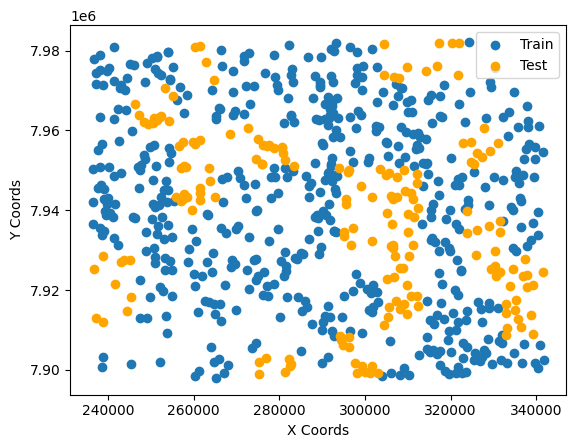

In [ ]:
balanced = create_block_fold(df_x = df.x,
                  df_y = df.y,
                  spacing=10000,
                  n_splits = 4,
                  random_state = 42)

X_train, X_test, y_train, y_test, coord_train, coord_test = fold_train_test_split(fold_param = balanced,
                                                                                  X = X,
                                                                                  y = Y)





# Plot X_train
plt.scatter(coord_train[0], coord_train[1], label='Train', marker='o')

# Plot X_test in Orange
plt.scatter(coord_test[0], coord_test[1], label='Test', marker='o', color='orange')

# Set labels and title
plt.xlabel('X Coords')
plt.ylabel('Y Coords')
plt.legend()

plt.show()

In [ ]:
inner_balanced = create_block_fold(df_x = X_train[:,1],
                                  df_y = X_train[:,0],
                                  spacing=10000,
                                  n_splits = 4,
                                  random_state = 42)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 3000, num = 20)]
# Number of features to consider at every split
max_features = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
# Maximum number of levels in tree
bootstrap = [False, True]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
        'max_features': max_features,
        'bootstrap': bootstrap}

In [ ]:
#finding the best hyperparameters
best_params, metrics = hyperparameter_tuning(clf = RandomForestRegressor(),
                                                param_grid = param_grid,
                                                X_train = X_train,
                                                y_train = y_train,
                                                X_test = X_test,
                                                y_test = y_test,
                                                cv = inner_balanced,
                                                random_state=42)

print('Best Params:', best_params)
print('Hyperparameter tuning metrics: ', metrics)

In [ ]:
overall_metrics = []


for inner_train_idx, inner_val_idx in inner_balanced:

    #generating inner train and test for X variable
    X_inner_train = X_train[inner_train_idx]
    X_inner_test = X_test[inner_val_idx]


    #the same as above but for Y
    y_inner_train = y_train[inner_train_idx]
    y_inner_test = y_test[inner_val_idx]

    inner_clf = RandomForestRegressor(**best_params)

    inner_clf.fit(X_inner_train, y_inner_train)

    y_inner_pred = inner_clf.predict(X_inner_test)

    r2_i = r2_score(y_inner_test, y_inner_pred)
    rmse_i = mean_squared_error(y_inner_test, y_inner_pred, squared=False)

    inner_metrics = [r2_i, rmse_i]
    overall_metrics.append(inner_metrics)

print(overall_metrics)

##2. Build a pipeline of training

## 3.Hyperparameter Tuning

## 4. Train XGBoost Model

##5. Model Evaluation

## 6. Feature Importance Measurement

## 7. References

https://archive.is/Pndsc#selection-3265.283-3265.322

https://machinelearningmastery.com/xgboost-for-regression/

https://arxiv.org/pdf/1603.02754.pdf

https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

https://medium.com/analytics-vidhya/hyper-parameter-tuning-gridsearchcv-vs-randomizedsearchcv-499862e3ca5

https://www.youtube.com/watch?v=aLOQD66Sj0g

• If you had a 3-month extra to work on this problem, what experiment(s) would you run? If you propose
several of them, explain which one is the most important. Justify what it will bring to the analysis.

- Experiment with the effect of spatial autocorrelation
It is important because when models disregard the influence of SA. Overlooking this correlation result in over-optimistic models that fail to account for the geographical configuration of data.
- experiment with semivariogram model
to reduce over-optimistic and biased errors.